# Introducción

___



En la primer clase se repasamos algunos conceptos clásicos sobre el aprendizaje automático. Se repasaron ahí las aproximaciones de aprendizaje supervisado, no supervisado y por refuerzo.  

Los objetivos de este _notebook_ son:
1. Cimentar algunos conceptos básicos que seguiremos viendo a lo largo del curso cuando pasemos a modelos de aprendizaje profundo (_e.g._ procesamiento de datos, funciones de pérdida, _overfitting_).
2. Ver estos conceptos en acción en un caso de aprendizaje supervisado y uno no supervisado.
3. Familiarizarnos con rudimentos de PyTorch, una librería que utilizaremos de ahora en más.

Para ello vamos a analizar un _dataset_ muy popular, llamado comunmente "_penguins dataset_". Utilizaremos estos datos para predecir el valor de una variable en función de otra (i.e., una regresión lineal) y realizar una clasificación de cada individuo en base a sus características (_i.e._, _clustering_ de los datos).


> **Nota**: Este _notebook_ está inspirado en trabajo realizado por el Dr. Ignacio Ramírez para el curso "_Aprendizaje automático básico para científicos (AABC)_", el cual compartió amablemente materiales. Dicho curso también se encuentra organizado por CICADA.


___

**TO-DO**: 
    - incorporar temas del overfitting, bias-variance, etc
    - Ver bien como hacer para ver el resultado del entrenamiento y contrastarlo con un SGD sacado con sklearn
    - Pensar si no hay otra alternativa con PyTorch para el aprendizaje no supervisado
    - Meterle lo del overfitting capaz con el problema de los picos. Ver si no se puede aprender una función mas compleja que tome en cuenta las dos medidas para sacar el peso, por ejemplo (tiene sentido esto? habra informacion redundante? pensando en voz alta...)
    - Ver como mechar mejor lo del aprendizaje no supervisado...
    - Mechar ejercicios en el medio de las cosas
    - AUC para el caso de prediccion?
    - invertir el orden: arrancamos con kNN, luego vamos a lo otro, como ejercicio final vemos como hacer un clasificador para volver a la parte del principio
___

# _"Penguins dataset"_, nuestro objeto de estudio

*Tiempo estimado: ~x horas*

___


<div>
<center>
<img src="https://imgur.com/orZWHly.png" width="60%"/>
</center>
</div>

El [Penguins Dataset](https://github.com/allisonhorst/palmerpenguins) se trata de un _dataset_ donde se listan 5 caracteristicas para tres especies distintas de pingüinos. Los datos son: el sexo del pingüino, largo y ancho del pico ("_bill_" en ingles), el largo de la aleta ("_flipper_") y el peso en gramos de cada individuo.

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/man/figures/culmen_depth.png" width="500" />
</div>

En el mismo hay tres especies distribuidas en distintas islas del Archipielago de Palmer.

Como primera tarea vamos a observar nuestros datos, en lo que típicamente se llama un "análisis exploratorio".

## Análisis exploratorio del _dataset_

El primer paso es, naturalmente, importar los datos. Afortunadamente, la librería _seaborn_ posee al _dataset_ entre los datos disponibles

In [1]:
# cargamos las librerias
import seaborn as sns,  pandas as pd

# importamos el dataset
penguins = sns.load_dataset('penguins')

# llevamos al dataset a un dataframe de pandas
data = pd.DataFrame(penguins)

In [2]:
# pispeamos los datos
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Vemos que cada fila corresponde a un individuo. En las columnas se encuentran las variables que ya habíamos mencionado

In [3]:
# con el metodo .info() podemos ver un poco más, incluyendo datos faltantes por variable
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [4]:
# con shape podemos ver las dimensiones del dataset 
print(data.shape) # cuantos individuos hay?

(344, 7)


In [5]:
# con el metodo .describe() podemos obtener algunos datos mas cuantitativos de cada variable
data.describe(include='all')

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,333
unique,3,3,NaN,NaN,NaN,NaN,2
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,Male
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


## Análisis exploratorio del _dataset_

El primer paso es, naturalmente, importar los datos. Afortunadamente, la librería _seaborn_ posee al _dataset_ entre los datos disponibles

In [61]:
# cargamos las librerias
import seaborn as sns,  pandas as pd
import matplotlib.pyplot as plt
pd.set_option("compute.use_numexpr", False)

# importamos el dataset
penguins = sns.load_dataset('penguins')

data = pd.DataFrame(penguins)

In [62]:
# pispeamos los datos
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Vemos que cada fila corresponde a un individuo. En las columnas se encuentran las variables que ya habíamos mencionado

In [63]:
# con el metodo .info() podemos ver un poco más, incluyendo datos faltantes por variable
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [64]:
# con shape podemos ver las dimensiones del dataset 
print(data.shape) # cuantos individuos hay?

(344, 7)


In [65]:
# con el metodo .describe() podemos obtener algunos datos mas cuantitativos de cada variable
data.describe(include='all')

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,333
unique,3,3,NaN,NaN,NaN,NaN,2
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,Male
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


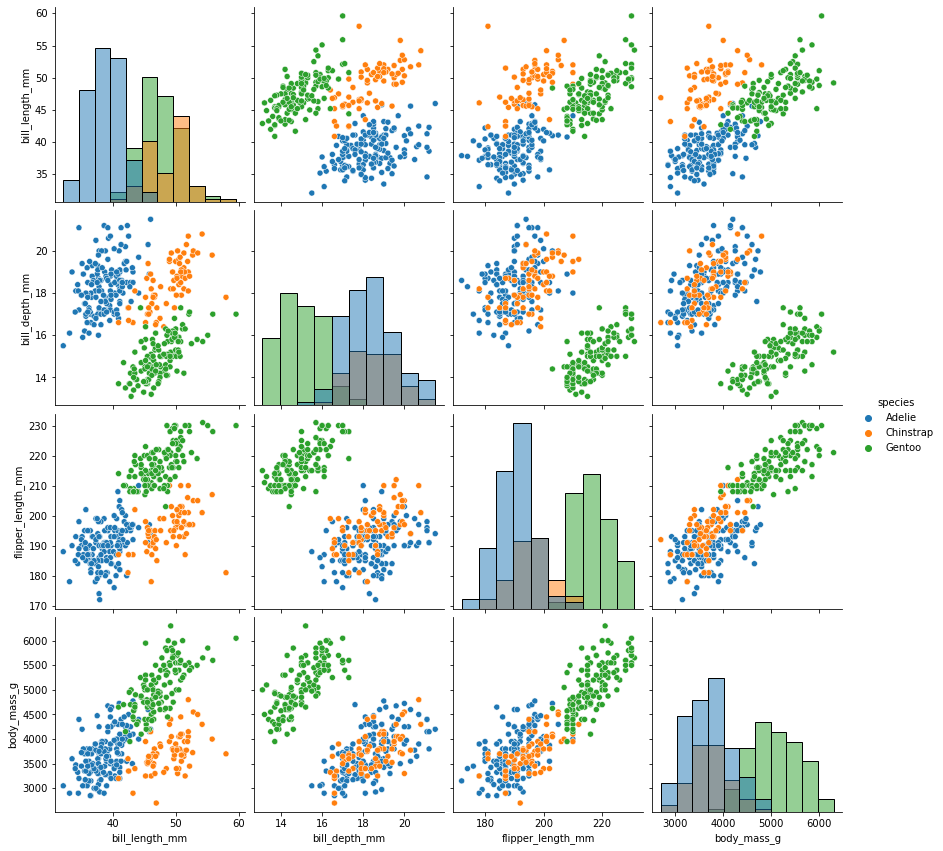

In [66]:
sns.pairplot(data, hue="species", height=3,diag_kind="hist")

Vemos, por ejemplo, que las diferentes especies de pingüino tienen diferente relación para las variables `bill_depth_depth` y `bill_length_mm`

<AxesSubplot:xlabel='bill_length_mm', ylabel='bill_depth_mm'>

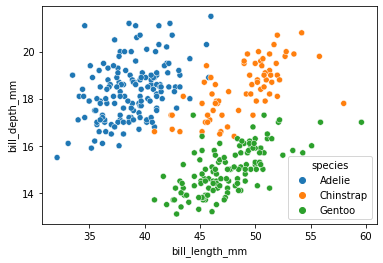

In [67]:
sns.scatterplot(data = data, hue = 'species', x = 'bill_length_mm', y = 'bill_depth_mm')

Teniendo en cuenta esto, una pregunta natural sería: ¿podríamos predecir la especie de pingüino en base a estas dos medidas del pico de una forma eficiente?

# Aprendizaje no supervisado

Para abordar este problema vamos primero a tomar un enfoque de **aprendizaje no supervisado**. Bajo este enfoque no vamos a codificar explícitamente en nuestro algoritmo de aprendizaje a qué especie pertenece cada pingüino. El princpio que opera es el siguiente: si la relación entre las variables que usamos para entrenar correlaciona bien con la especie del individuo, un algoritmo de aprendizaje eficaz debería ser capaz de detectar grupos de individuos con características similares; estos grupos deberían correlacionar con las especies de los individuos.

Para ilustrar este concepto, vemos a continuación cómo funciona el algoritmo que vamos a emplear: ***k-means clustering***. 

![Explicación visual del algoritmo kNN. Tomado de www.tidymodels.org](https://raw.githubusercontent.com/mauriciolangleib/capibara_cicada_2025/refs/heads/main/imgs/kNN_explicado.gif)

> **Nota**: Para más información sobre el algoritmo de _k-means clustering_, se pueden ver recursos como https://scikit-learn.org/stable/modules/clustering.html#k-means.

Muy bien, ahora tenemos varias cuestiones a abordar:

1. ¿**Cómo vamos a implementar** el algoritmo?
2. ¿Qué **parámetros** vamos a emplear? Pensemos que tenemos parámetros como el _número de centroides ($k$)_ o la _distancia a emplear_.
3. ¿Cómo vamos a **medir** el éxito de nuestra aproximación?

Resolvamos estas preguntas una a una.

Para llevar a cabo la clasificación en base al algoritmo de _k-means clustering_ podríamos escribir código que haga esto sin un esfuerzo muy grande (ver, por ejemplo, https://www.kaggle.com/code/fareselmenshawii/kmeans-from-scratch). **En este práctico optamos por no tomar esta aproximación, en tanto no es un curso de _machine learning_ desde cero**; estamos utilizando este ejercicio para refrescar conceptos que se supone viste alguna vez. No obstante, si sentís que la idea de implementar esto de cero sería algo imposible, puede ser interesante que veas el código del ejemplo (u otras implementaciones), solo para desmitificar esto.

In [68]:
from sklearn.cluster import KMeans # traemos k-means clustering de sk-learn

Pronto, con esta simple línea de código vamos a poder utilizar el algoritmo sobre nuestros datos sin problemas!

Respecto a los parámetros a emplear

In [69]:
data_k = data.query("not body_mass_g.isnull() and not flipper_length_mm.isnull()", engine = 'python')

In [70]:
from sklearn.model_selection import train_test_split # separación de datos en entrenamiento, testeo y validación
X = data_k[['bill_depth_mm','bill_length_mm']].to_numpy()
y = data_k.species.to_numpy()

In [71]:
kmeans= KMeans(n_clusters = 3, random_state = 42)

# Compute k-means clustering
kmeans.fit(X)

# Compute cluster centers and predict cluster index for each sample.
pred = kmeans.predict(X)

pred


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,

In [72]:
import matplotlib.pyplot as plt

In [73]:
pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,

In [74]:
data_k = data_k.assign(species_pred = pred)

In [75]:
data_k

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,species_pred
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,2
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,2
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,2
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,2
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,2
...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female,0
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female,0
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male,1
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female,0


In [79]:
data_k = data_k.query("not body_mass_g.isnull() and not flipper_length_mm.isnull()", engine = 'python')

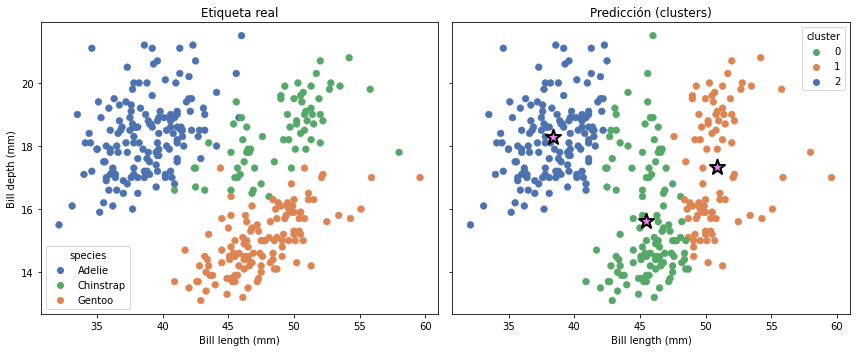

In [80]:
# ----- Paleta: seaborn deep en orden azul, verde, naranja -----
deep = sns.color_palette("deep")
COLORS = [deep[0], deep[2], deep[1]]  # azul, verde, naranja

# Hardcode de colores por cluster (ajustá las claves si tus labels no son 0/1/2)
CLUSTER_COLORS = {0: COLORS[1], 
                  1: COLORS[2], 
                  2: COLORS[0]}

# Colores para etiquetas reales (mismo set, en el mismo orden determinista)
species_order = sorted(data_k['species'].astype(str).unique())
SPECIES_COLORS = {sp: COLORS[i % len(COLORS)] for i, sp in enumerate(species_order)}

# Asegurar hue categórico para evitar el problema de “2 colores”
data_k['cluster'] = pd.Categorical(data_k['species_pred'], categories=list(CLUSTER_COLORS.keys()))

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Panel A: etiqueta real
sns.scatterplot(
    data=data_k, x='bill_length_mm', y='bill_depth_mm',
    hue='species', hue_order=species_order, palette=SPECIES_COLORS,
    s=45, edgecolor=None, ax=axes[0]
)
axes[0].set_title('Etiqueta real')
axes[0].set_xlabel('Bill length (mm)')
axes[0].set_ylabel('Bill depth (mm)')
axes[0].legend(title='species')

# Panel B: predicción (clusters)
cluster_order = list(CLUSTER_COLORS.keys())
sns.scatterplot(
    data=data_k, x='bill_length_mm', y='bill_depth_mm',
    hue='cluster', hue_order=cluster_order, palette=CLUSTER_COLORS,
    s=45, edgecolor=None, ax=axes[1]
)
axes[1].set_title('Predicción (clusters)')
axes[1].set_xlabel('Bill length (mm)')
axes[1].set_ylabel('')

# Centroides (media por cluster en las dos variables ploteadas)
cent = (data_k
        .groupby('cluster')[['bill_length_mm', 'bill_depth_mm']]
        .mean()
        .reindex(cluster_order))

axes[1].scatter(
    cent['bill_length_mm'], cent['bill_depth_mm'],
    marker='*', s=250, linewidths=2, edgecolors='black',  
    c='violet', label='Centroides'
)

plt.tight_layout()
plt.show()

Como podemos ver... **TO-DO**: rellenar esto...

___

**Conclusión:**...

> **Nota**: <esta nota es sobre como el aprendizaje no supervisado también se puede llamar **X**, algo sobre la estructura de los datos y eso, y como en el concepto de espacio latente y eso vamos a ver esto en deep learning>
___

Sumar que, como vamos a ver, esta tarea también puede ser tomada para el aprendizaje supervisado (como vamos a ver al final del práctico)

## Aprendizaje supervisado: prediciendo valores contínuos

Una aproximación distinta es la que llamamos **aprendizaje supervsisado**.


> Poner más data sacada de AABC...
>
> 

Para arrancar podemos ver como correlacionan

Correlacion:


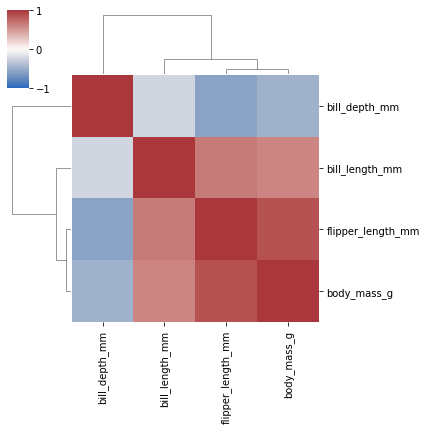

In [81]:
# calculamos la correlacion y agrupamos jerarquicamente usando el metodo .clustermap()
print('Correlacion:')
sns.clustermap(data.drop(['species', 'island','sex'], axis = 1).corr(),  
               figsize = (6,6), 
               cmap = 'vlag',
               vmax = 1, vmin = -1)

Podemos concluir entonces... **TODO**: completar...

___

**Pasemos ahora a intentar predecir, por ejemplo, el peso de un individuo a partir del largo de su aleta**, dado que estas dos variables parecen fuertemente correlacionadas. Para llevar a cabo esta tarea vamos a hacer una regresión lineal. 


Nos enfrentamos a un típico caso de ***aprendizaje supervisado***. Haremos una primer aproximación donde para una fracción de datos intentaremos hacer una predicción. Estimaremos el error en nuestro conjunto y en un conjunto de ***testeo***, que todavía no hayamos visto. Intentaremos luego modificar los pesos en nuestro modelo en una dirección donde el cambio sea favorable a realizar mejores predicciones; iteraremos el proceso durante varias ***épocas***.

**TO-DO**: incluir el concepto de validation set.


Antes que nada, veamos la relación entre las dos variables seleccionadas

<AxesSubplot:xlabel='flipper_length_mm', ylabel='body_mass_g'>

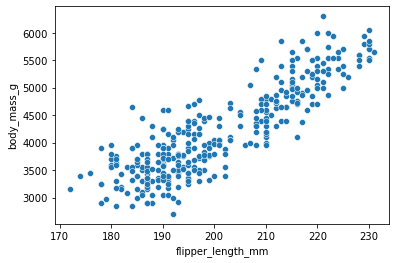

In [82]:
sns.scatterplot(data = data, x = 'flipper_length_mm', y = 'body_mass_g')

<AxesSubplot:xlabel='flipper_length_mm', ylabel='body_mass_g'>

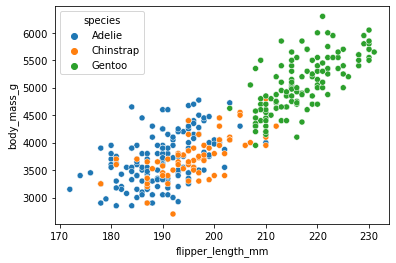

In [83]:
# vemos lo mismo segun especie?
sns.scatterplot(data = data, x = 'flipper_length_mm', y = 'body_mass_g', hue = 'species')

La relación entre ambas variables se ve bastante lineal. Podemos explorar aparte si otras variables... [**TODO**: completar]

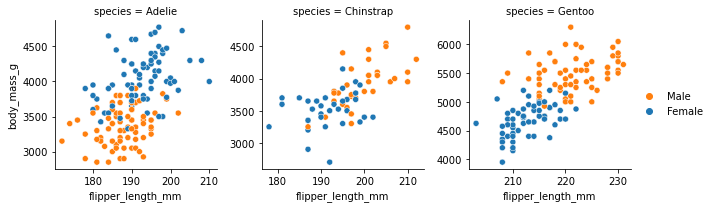

In [84]:
# y por sexo?
g = sns.FacetGrid(data, col="species", sharey = False, sharex = False)
g.map_dataframe(sns.scatterplot, x="flipper_length_mm", y="body_mass_g", hue="sex")
g.add_legend()

Ya nos divertimos un poco con los datos. Respecto a nuestra preocupación inicial (si la relación entre ambas variables podría ser estimada mediante una regresión lineal) parecería que podemos quedarnos tranquilos.

Ahora, cómo podríamos hacer esto en Python? Existen muchas formas. Como ya dijimos, el objetivo de este práctico es familiarizarnos con herramientas básicas de PyTorch, una librería para armar y entrenar modelos de aprendizaje profundo con la que vamos a trabajar el resto del curso. Teniendo en cuenta esto, naturalmente lo que nos interesa es aproximarnos a la regresión lineal desde la perspectiva de una red neuronal.

Seguramente ya te encontraste en varios cursos con regresiones lineales. La regresión lineal es un método que nos permite evaluar si entre dos variables existe una relación lineal y una vez determinada tal relación, predecir una de las variables a partír de la otra. Es decir, ajustaremos una recta a la relación entre nuestras dos variables medidas. Para eso, suponemos que nuestra variable dependiente (y) cambia en función de nuestra variable independiente (x) según la siguiente expresión:

$$y = ax + b$$

Tengamos en cuenta que entonces que, si tenemos $n$ pares de observaciones $(x_i,y_i)$, podemos expresar esto con notación matricial como

$$\begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix} = a \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix} + b$$

o, lo que es más sencillo

$$ \mathbf{\hat{y}} = a\mathbf{x} + b$$

donde simplemente hicimos un cambio de notación.

En la siguiente clase vamos a ver que de la misma forma podemos pensar a un modelo sencillo llamado el **perceptrón**. Traemos a colación esto en nuestro clase porque, cuando hagamos una implementación con PyTorch, la forma en la que lo haremos ...

> TODO: terminar esto bien...
> red neuronal que toma $n$ valores de entrada y devuelve un valor de salida.

___

Debemos encontrar, entonces, los parámetros $a$ y $b$ que mejor se ajustan a nuestro _set_ de datos. Luego, a partir de estos parámetros podremos predecir valores de $y$ para valores de $x$ no medidos.


Para estimar estos parámetros emplearemos un método llamado 'mínimos cuadrados', que busca minimizar el error entre cada observación y el valor predicho por nuestra ecuación de la recta.

Podemos definir el error para un determinado dato $x_i$ como $$r_i = y_i - (ax_i + b)$$

Es decir, la diferencia entre el valor observado $y_i$ y el que estimamos $ax_i+b$.
Luego, para estimar los valores de $a$ y $b$, la estrategia es minimizar el error total de nuestra regresión, o sea la suma de todos los errores individuales $r_i$. De forma que nuestro error total ($e$) valdrá:

$$e = Σ^N_{i=1}r_i^2=Σ^N_{i=1}(y_i-(ax_i +b))^2$$


Queremos ahora hallar los valores de $a$ y $b$ que minimizan este error total. 


Una forma para hacer esto es tomar una ***aproximación analítica*** (i.e., buscando la solución exacta con ecuaciones). Hallamos las derivadas parciales de $e$ respecto de $a$ y de $b$, y las evaluamos en 0 (buscando así los valores que maximizan). De esta forma se ob†iene:

$$a={Σ^N_{i=1} (x_i - x̄)(y_i - \overline{y}) \over \Sigma (x_i - \overline{x})^2}$$

y

$$b = \overline{y} - a * \overline{x}$$

Implementemos nuestra solución entonces para estimar la masa en gramos de un pingüino en base a el largo de su aleta

In [89]:
import numpy as np

In [90]:
data_r = data.query("not flipper_length_mm.isnull() and not body_mass_g.isnull()", engine = 'python')

In [91]:
# guardamos ambos valores
largo_aletas = data_r.flipper_length_mm.to_numpy() * 0.1 # lo llevamos a un array de numpy con datos en cm
masa_pinguinos = data_r.body_mass_g.to_numpy() * 1e-3 # llevamos a kg

# sacamos los promedios para estos valores
largo_promedio_aleta = np.mean(largo_aletas)
masa_promedio_pinguinos = np.mean(masa_pinguinos)

**Adaptar esto**

> Chapter 6 introduced iterative optimization algorithms. These are general-purpose meth-
ods for finding the minimum of a function. In the context of neural networks, they find
parameters that minimize the loss so that the model accurately predicts the training
outputs from the inputs. The basic approach is to choose initial parameters randomly
and then make a series of small changes that decrease the loss on average. Each change is
based on the gradient of the loss with respect to the parameters at the current position.

In [92]:
# Primero inicializamos el numerador y denominador para el parámetro a, que luego modificaremos en un loop for
numerador = 0 ;
denominador = 0 ;

for i in range(len(largo_aletas)):
  numerador += (largo_aletas[i]-largo_promedio_aleta)*(masa_pinguinos[i]-masa_promedio_pinguinos)
  denominador += (largo_aletas[i]-largo_promedio_aleta)**2 # El operador ** es el 'elevado a' de Python

a = numerador / denominador
b = masa_promedio_pinguinos - a * largo_promedio_aleta

print(a,b)

0.4968556640610008 -5.780831358077062


Notamos que, como habíamos visto, a mayor largo de aleta, mayor es la masa de los pingüinos (esto se deduce de $a > 0$). Particularmente, podemos describir la masa de los pingüinos ($y$) como una función del largo de aleta ($x$) de la siguiente manera:
$$ y = 0.49 x - 5.78 $$

Grafiquemos esta relación junto con nuestros datos para observarlo mejor.

In [ ]:
59𝑥59𝑥

In [95]:
a

0.4968556640610008

In [96]:
b

-5.780831358077062

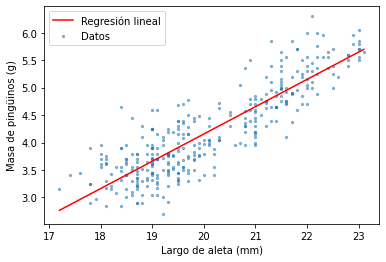

In [97]:
x = np.linspace(np.min(largo_aletas), np.max(largo_aletas), 1000)
y = a*x + b

fig, ax = plt.subplots()
#Graficamos nuestos puntos
ax.scatter(largo_aletas, masa_pinguinos, alpha=0.5,s=5, label='Datos') #seteamos la opacidad (alpha) y el tamaño (s) de los puntos ya que muchos se solapan y de esta forma podemos distinguirlos mejor
#Graficamos la regresión lineal
plt.plot(x,y,color='red', label='Regresión lineal')
#Seteamos los nombres de los ejes
ax.set_xlabel('Largo de aleta (mm)')
ax.set_ylabel('Masa de pingüinos (g)')
#Le decimos que muestre la leyenda y por último que grafique
ax.legend()
plt.show()


Si bien a simple vista parece ajustarse bastante bien, debemos definir una forma cuantitativa para evaluar qué tan bien se ajusta nuestro modelo. Usaremos dos: el error cuadrático medio (RMSE) y el coeficiente de determinación ($R^2$)

El RMSE es la raiz del promedio de los cuadrados de todos los errores. Matemáticamente: $$ RMSE = \sqrt {{1 \over N}Σ^N_{i=1}(y_i-y^p_i)^2}$$ Donde $y^p_i$ es el y predicho por nuestra regresión para ese valor.

In [98]:
#Calculemos el RMSE
suma_cuadrados = 0
N = len(largo_aletas)

for i in range(N):
  y_pred = a*largo_aletas[i] + b
  suma_cuadrados += (largo_aletas[i]-y_pred)**2

RMSE = np.sqrt(suma_cuadrados/N)

print('RMSE: ' + str(RMSE))

RMSE: 15.905463491279711


Ahora, el coeficiente de determinación $R^2$ es la porción de la varianza total que se explica por nuestra regresión. Matemáticamente:
$$R^2 = {\Sigma^N_{i=1} (y^p_i -\overline{y})^2 \over \Sigma^N_{i=1}(y_i - \overline{y})^2}$$

In [99]:
#Calculemos R^2
numerador = 0
denominador = 0

for i in range(N):
  y_pred = a*largo_aletas[i] + b
  numerador += (y_pred-masa_promedio_pinguinos)**2
  denominador += (masa_pinguinos[i]-masa_promedio_pinguinos)**2

R2 = (numerador/denominador)
print('R^2: ' + str(R2))

R^2: 0.7589925193571173


Lo cual es una correlación bastante buena teniendo en cuenta que estos son datos biológicos reales!

___

Muy bien, ahora tomemos una segunda aproximación a este problema de determinar (o, en este caso, podríamos decir ***aprender***) qué valores de $a$ y $b$ ajustarían mejor a nuestros datos.

Imaginemos que no tuvieramos una solución analítica a este problema: en la vida real esto pasa en muchas situaciones, ya sea porque las ecuaciones que describen razonablemente la realidad no tienen soluciones exactas, o porque directamente no tenemos una ecuación realista que sepa capturar la relación en nuestros datos.

**Podemos resolver el problema de alguna forma?** Si la respuesta fuese no, el notebook no seguiría y el curso sería bastante corto 🙂.  

Recordemos que nuestra solución **minimiza el error** para nuestro set de datos. Entonces, lo que podemos hacer es calcular el error e intentar disminuirlo iteración a iteración modificando los valores de $a$ y $b$. Podemos, por ejemplo, variar $a$ hasta encontrar que ni aumentarlo ni disminuirlo mejoran nuestro error, y luego pasar a hacer lo mismo con $b$.

Veamos si esto funciona

## Buscando minimizar la función de pérdida

> La función que puede usarse fácil en las diapos para explicar gradient descent es f(x)=2x²-2, que tiene mínimo en  0. La derivada es f'(x)=4x y por lo tanto dx=x{t-1}-4ex{t-1} , o sea xt=x0(1-4e)^t que converge si e<1/4

> The loss depends on the network parameters, and this chapter considers how to find
the parameter values that minimize this loss. This is known as learning the network’s
parameters or simply as training or fitting the model. The process is to choose initial
parameter values and then iterate the following two steps: (i) compute the derivatives
(gradients) of the loss with respect to the parameters, and (ii) adjust the parameters
based on the gradients to decrease the loss. After many iterations, we hope to reach the
overall minimum of the loss function.

$$\hat{\phi} = \text{argmin}_\phi^{} \ L[\phi]$$

El más simple de estos métodos se llama _descenso por gradiente_. Si tenemos $N$ parámetros, donde $\phi = [\phi_1, \phi_2, \dots, \phi_N]^T$, el descenso por gradiente se compone esencialmente de dos pasos

1. **Computar el gradiente de la función de pérdida respecto a los parámetros**, es decir

$$\frac{\partial L}{\partial \phi} = \begin{bmatrix} \frac{\partial L}{\partial \phi_1} \\ \frac{\partial L}{\partial \phi_2} \\ \vdots \\ \frac{\partial L}{\partial \phi_N} \end{bmatrix}$$

2. **Actualizar los parámetros**. Esto se hace teniendo en cuenta el gradiente y un factor de escalado $\alpha$ (generalmente llamado _learning rate_), siguiendo

$$\phi_{i+1} \leftarrow \phi_i - \alpha \cdot \frac{\partial L}{\partial \phi}$$

en donde cada parámetro $\phi_i$ se actualiza según el correspondiente valor $-\alpha \cdot \frac{\partial L}{\partial \phi_i}$ (es decir, cuánto su cambio infinitesimal modifica a la función de pérdida, multiplicado por el _learning rate_ $\alpha$). El signo de menos nos asegura el ir en contra del gradiente (i.e., buscar el descenso de la función de pérdida).

___

Refresquemos estos conceptos con un caso bien sencillo. Consideremos que tenemos una función de pérdida cuya dependencia respecto a los parámetros está descrita por $L [\phi] = 2\phi^2 -2$, donde el único parámetro en el modelo es $\phi$. 

En un momento dado, el parámetro es $\phi_0 = -3$, lo cual implica que el _loss_ es de $L[\phi] = 16$.


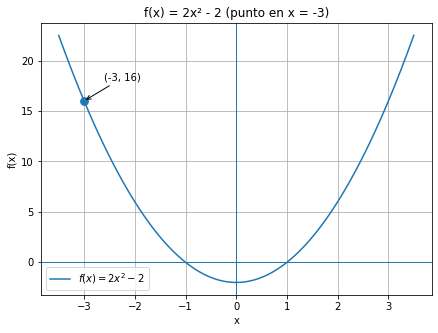

In [104]:
# Gráfico de f(x) = 2x^2 - 2 con un punto marcado en x = -3
import numpy as np
import matplotlib.pyplot as plt

# Dominio y función
x = np.linspace(-3.5, 3.5, 400)
f = 2*x**2 - 2

plt.figure(figsize=(7, 5))
plt.plot(x, f, label=r"$f(x)=2x^2-2$")
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)

# Punto en x = -3
x0 = -3
y0 = 2*(x0**2) - 2  # 16
plt.scatter([x0], [y0], s=60, zorder=3)
plt.annotate(f"(-3, {y0:.0f})", xy=(x0, y0), xytext=(-2.6, y0+2),
             arrowprops=dict(arrowstyle="->"))

plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("f(x) = 2x² - 2 (punto en x = -3)")
plt.grid(True)
plt.legend()
plt.show()


¿Cómo funcionaría el gradiente por descenso en este caso, si tomamos un _learning rate_ $\alpha = 0.05$. Hagamos un _for loop_ para verlo. Pediremos al algoritmo que se detenga cuando el cambio de _loss_ $\Delta L$ sea arbitrariamente chico (digamos, $1e-12$. Recordemos que en este caso tenemos

$$L [\phi] = 2\phi^2 -2 \rightarrow \frac{\partial L}{\partial \phi} = 4 \phi$$

lo cual emplearemos en nuestra implementación del algoritmo

In [109]:
# inicializamos
tolerancia = 1e-12
L = 16
phi = -3
diff_L = np.inf # incializamos con una diferencia infinita
i = 1
alpha = 0.05

print('===================================================================================================================')
while diff_L > tolerancia:
    dL_dphi = 4*phi # calculamos la derivada en el punto
    phi = phi - 0.05*dL_dphi # actualizamos el parametro
    L_nuevo = 2*(phi**2) -2 # calculamos el nuevo loss
    diff_L = np.abs(L-L_nuevo) # calculamos la diferencia de loss
    print(f'Iteracion: {i}; dL/dphi = {dL_dphi}; phi_{i+1} = {phi}; delta L = {diff_L}')# imprimimos
    L = L_nuevo # actualizamos loss
    i += 1
print('===================================================================================================================')

Iteracion: 1; dL/dphi = -12; phi_2 = -2.4; delta L = 6.48
Iteracion: 2; dL/dphi = -9.6; phi_3 = -1.92; delta L = 4.1472
Iteracion: 3; dL/dphi = -7.68; phi_4 = -1.536; delta L = 2.6542079999999997
Iteracion: 4; dL/dphi = -6.144; phi_5 = -1.2288000000000001; delta L = 1.6986931199999997
Iteracion: 5; dL/dphi = -4.9152000000000005; phi_6 = -0.9830400000000001; delta L = 1.0871635968
Iteracion: 6; dL/dphi = -3.9321600000000005; phi_7 = -0.7864320000000001; delta L = 0.695784701952
Iteracion: 7; dL/dphi = -3.1457280000000005; phi_8 = -0.6291456000000001; delta L = 0.4453022092492802
Iteracion: 8; dL/dphi = -2.5165824000000003; phi_9 = -0.5033164800000001; delta L = 0.28499341391953914
Iteracion: 9; dL/dphi = -2.0132659200000003; phi_10 = -0.40265318400000005; delta L = 0.18239578490850517
Iteracion: 10; dL/dphi = -1.6106127360000002; phi_11 = -0.32212254720000005; delta L = 0.11673330234144341
Iteracion: 11; dL/dphi = -1.2884901888000002; phi_12 = -0.25769803776000005; delta L = 0.074709313

In [112]:
from matplotlib import cm
from matplotlib.colors import Normalize

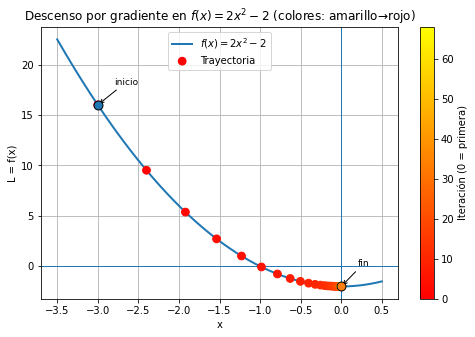

In [113]:
# Parámetros
tolerancia = 1e-12
phi = -3.0               # x inicial
alpha = 0.05             # tasa de aprendizaje
max_iter = 10_000

# Función y gradiente
f = lambda x: 2*x**2 - 2
df = lambda x: 4*x

# Historial
phis = [phi]
Ls = [f(phi)]
deltas = [np.nan]  # delta L para la primera fila

# Loop de descenso por gradiente
L_prev = Ls[-1]
i = 1
while i <= max_iter:
    g = df(phi)
    phi = phi - alpha * g
    L_new = f(phi)
    diff_L = abs(L_prev - L_new)
    
    phis.append(phi)
    Ls.append(L_new)
    deltas.append(diff_L)
    
    if diff_L <= tolerancia:
        break
    L_prev = L_new
    i += 1

# Tabla con el historial
hist = pd.DataFrame({
    "iter": range(len(phis)),
    "x": phis,
    "L": Ls,
    "delta_L": deltas
})

In [ ]:
# Gráfico
x_grid = np.linspace(min(phis)-0.5, max(phis)+0.5, 400)
y_grid = f(x_grid)

plt.figure(figsize=(8, 5))
plt.plot(x_grid, y_grid, linewidth=2, label=r"$f(x)=2x^2-2$")
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)

# Colorear puntos de amarillo (inicio) a rojo (final)
norm = Normalize(vmin=0, vmax=len(phis)-1)
colors = cm.get_cmap("autumn")(norm(range(len(phis))))
plt.scatter(phis, Ls, c=colors, s=60, zorder=3, label="Trayectoria")

# Colorbar
sm = cm.ScalarMappable(cmap="autumn", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label("Iteración (0 = primera)")

# Anotaciones de inicio y fin
plt.scatter([phis[0]], [Ls[0]], s=80, edgecolor="k", linewidth=1, zorder=4)
plt.annotate("inicio", xy=(phis[0], Ls[0]), xytext=(phis[0]+0.2, Ls[0]+2),
             arrowprops=dict(arrowstyle="->"), fontsize=9)
plt.scatter([phis[-1]], [Ls[-1]], s=80, edgecolor="k", linewidth=1, zorder=4)
plt.annotate("fin", xy=(phis[-1], Ls[-1]), xytext=(phis[-1]+0.2, Ls[-1]+2),
             arrowprops=dict(arrowstyle="->"), fontsize=9)

plt.xlabel("x")
plt.ylabel("L = f(x)")
plt.title("Descenso por gradiente en $f(x)=2x^2-2$ (colores: amarillo→rojo)")
plt.grid(True)
plt.legend()
plt.show()

Perfecto, hicimos una regresión lineal usando las funciones de sk-learn. **Pero no sabemos mucho qué pasó en el medio**

- **TODO**: escribir todo esto mejor, dar el pie a lo que viene

### Un desvío valioso: conceptos básicos de PyTorch

*Tiempo estimado: ~x horas*
___

Lo que sigue va a parecer un desvío. Vamos

> **Nota**: Esta sección está adaptada de un curso de NeuroMatch (https://deeplearning.neuromatch.io/tutorials), un recurso sumamente valioso que también te invitamos a estudiar.

In [52]:
import numpy as np


PyTorch es un paquete de computación científica basado en Python dirigido a dos tipos de
público:

-  Un sustituto de NumPy optimizado para la potencia de las GPU
-  Una plataforma de aprendizaje profundo que proporciona una flexibilidad
   y una velocidad significativas

En esencia, PyTorch ofrece algunas características clave:

- Un objeto [Tensor](https://pytorch.org/docs/stable/tensors.html) multidimensional, similar a [NumPy Array](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) pero con aceleración de GPU.
- Un motor **autograd** optimizado para calcular derivadas automáticamente.
- Una API limpia y modular para crear e implementar **modelos de aprendizaje profundo**.

Podemos encontrar más información sobre PyTorch en su página web y material asociado (https://pytorch.org/).

#### Section 2.1: Creating Tensors


There are various ways of creating tensors, and when doing any real deep learning project, we will usually have to do so.

**Construct tensors directly:**

---



In [53]:
# importando librerias
import torch, random

In [54]:
# We can construct a tensor directly from some common python iterables,
# such as list and tuple nested iterables can also be handled as long as the
# dimensions are compatible

# tensor from a list
a = torch.tensor([0, 1, 2])

#tensor from a tuple of tuples
b = ((1.0, 1.1), (1.2, 1.3))
b = torch.tensor(b)

# tensor from a numpy array
c = np.ones([2, 3])
c = torch.tensor(c)

print(f"Tensor a: {a}")
print(f"Tensor b: {b}")
print(f"Tensor c: {c}")

Tensor a: tensor([0, 1, 2])
Tensor b: tensor([[1.0000, 1.1000],
        [1.2000, 1.3000]])
Tensor c: tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)


**Some common tensor constructors:**

---

In [55]:
# The numerical arguments we pass to these constructors
# determine the shape of the output tensor

x = torch.ones(5, 3)
y = torch.zeros(2)
z = torch.empty(1, 1, 5)
print(f"Tensor x: {x}")
print(f"Tensor y: {y}")
print(f"Tensor z: {z}")

Tensor x: tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
Tensor y: tensor([0., 0.])
Tensor z: tensor([[[0., 0., 0., 0., 0.]]])


Notice that `.empty()` does not return zeros, but seemingly random numbers. Unlike `.zeros()`, which initialises the elements of the tensor with zeros, `.empty()` just allocates the memory. It is hence a bit faster if you are looking to just create a tensor.

### Task 6 -- Part (a): Creating a neural network in PyTorch
Here we will create our neural network in PyTorch, and have a general discussion on clean and messy ways of going about it.

The module `torch.nn` contains different classes that help you build neural network models. All models in PyTorch inherit from the subclass `nn.Module`, which has useful methods like `parameters()`, `__call__()`, and others.

`torch.nn` also has various layers that you can use to build your neural network. For example, we will use `nn.Linear` in our code below, which constructs a fully connected layer. `torch.nn.Linear` is a subclass of `torch.nn.Module`.

What exactly is a "layer"? It is essentially a step in the neural network computation. For example, the `nn.Linear` layer computes the linear transformation of the input vector $x$:

$$
y = W^T x + b
$$

where $W$ is the matrix of tunable parameters and $b$ is a bias vector.

We can also think of the ReLU activation as a "layer". However, there are no tunable parameters associated with the ReLU activation function.

The `__init__()` method is where we typically define the attributes of a class. In our case, all the "sub-components" of our model should be defined here.

The `forward` method is called when we use the neural network to make a prediction. Another term for "making a prediction" is **running the forward pass**, because information flows forward from the input through the hidden layers to the output. This builds a computational graph.

The `forward` method is called from the `__call__()` function of `nn.Module`, so that when we run `model(batch)`, the `forward` method is called.

### Summary of what we will do:
- First, we will create quite an **ugly network** to highlight how to make a neural network in PyTorch at a very basic level.
- We will then utilise `torch.nn.Sequential` as a **neater approach**.
- Finally, we will discuss how the **best approach** would be to write a class where various parameters (e.g. number of layers, dropout probabilities, etc.) are passed as arguments.


In [ ]:
from torch.nn import Module
from torch.nn import BatchNorm1d, Linear, ReLU, Dropout
from torch import Tensor


class FCNet(Module):
    """Fully-connected neural network."""

    # define __init__ function - model defined here.
    def __init__(self):
        pass

    # define forward function which calls network
    def forward(self, batch: Tensor) -> Tensor:
        pass


# define a model and print and test (try with torch.rand() function)

### Task 7: Selecting a loss function

- Cross-entropy is about the most common loss function for classification.
  - Details on this loss function are available in the [PyTorch docs](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
- Let's instantiate it together.

In [56]:
from torch.nn import CrossEntropyLoss

In [ ]:
## aca nosotros podriamos jugar con cosas que no sean MSE, que es el loss que usa el SGDRegressor de sklearn

### Task 8: Selecting an optimiser

While we talked about stochastic gradient descent in the slides, most people use the so-called [Adam optimiser](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

You can think of it as a more complex and improved implementation of SGD.

Here we will tell the optimiser what parameters to fit in order to minimise the loss.

In [ ]:
# Create an optimiser and give it the model's parameters.
from torch.optim import Adam

### Task 9: Writing basic training and validation loops

####  Applying an activation function to model outputs

Our model produces raw scores, called **logits**. These are unnormalized and can be positive or negative. On their own, logits are not directly interpretable.

To make sense of these outputs (e.g., “how confident is the model?”), we apply an **activation function** like `softmax`, which converts logits into **pseudo-probabilities**.

> **Important:** We do **not** apply this activation inside the model or during
> training. The loss function we’re using (`CrossEntropyLoss`) expects **raw logits** and handles this internally.  
> We only apply `softmax` **after training**, for tasks like evaluation or
> visualization.

In general, we don’t usually include the output activation function in the network itself because it’s often handled more efficiently and flexibly by the loss function. Keeping it separate makes it easier to swap in different losses or interpret raw logits directly during training and debugging.

<details>
<summary>Why softmax? And what’s this about thermodynamics?</summary>

- According to the
  [PyTorch documentation on `CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html),
  this loss combines `LogSoftmax` and `NLLLoss` into a single function — so we
  don’t need to apply softmax ourselves during training.
- [Documentation on `nn.Softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
  shows that it's appropriate when the prediction should be **exactly one of**
  the possible classes — like species `Adelie`, `Chinstrap`, or `Gentoo`.

### What does softmax do?

Softmax turns logits into probabilities — it's what lets us say "the model is 90% confident it's a penguin of species `Adelie`."

### Physics connection

If you’ve studied physics, it might remind you of the **partition function** in thermodynamics — softmax turns logits into a normalised probability distribution, just as a partition function normalises energy states.  This analogy appears in several places in machine learning under names like "temperature scaling" and "energy-based models".

### When not to use softmax?
This activation is **not appropriate** if you want to assign **multiple labels** to the same input (e.g. both "dog" _and_ "cat").

### Final note on softmax and argmax
Since softmax is **monotonic** (it preserves order), using `argmax` on logits gives the same result as `argmax` on softmax probabilities.  
That’s why we don’t need to apply softmax just to get the predicted class.
</details>

---

### Part (a) -- training and validation loops

Have a go at writing the training and evaluation loops. Use the tips below to guide you.

#### Tips

- Configure the model separately for **training** and **validation**.
- Don't worry about storing metrics just yet, focus on the training and validation loops.
- Try to get it training first before implementing the validation loop. We will guide you through this process.

<details>
<summary>How does the loss **know** about parameters in the model? </summary>

- PyTorch tensors can track operations when `requires_grad=True`.
- When we run the **forward pass** (`preds = model(batch)`), PyTorch builds a **dynamic computation graph** that records all operations, including how the model's parameters were used to compute the predictions.
- The **loss** (`loss = criterion(preds, targets)`) depends on the predictions, so it's also connected to the model parameters via this graph.
- Calling `loss.backward()` performs the **backward pass**, where PyTorch:
  - Traverses the computation graph,
  - Computes gradients of the loss w.r.t. each parameter that requires gradients.

> `loss.backward()` **computes gradients but does not update** parameters. You need to call `optimizer.step()` to apply the updates.

Because PyTorch uses a **dynamic graph**, the graph is recreated on every forward pass, making it flexible and easy to debug.


</details>

<details>
<summary>PyTorch Autograd and <code>requires_grad</code></summary>

**NOTE:** In PyTorch, `requires_grad=True` is set automatically for the parameters of layers defined using `torch.nn.Module` subclasses.

Here’s a simple example:

```python
x = ones(10, requires_grad=True)
y = 2 * x.exp()
print(y)
```
</details>

<details>
<summary>Don't forget: Optimizer accumulates gradients</summary>

By default, PyTorch accumulates gradients each time you call `loss.backward()`.  
You must reset them manually with `optimizer.zero_grad()` before each training step.

</details>

<details>
<summary>Evaluation tip: Disable gradients</summary>

Use the decorator  `@no_grad()` or context `with no_grad():` during evaluation or inference.  
This saves memory and speeds things up by skipping gradient tracking.

</details>

---

### Part (b) -- tracking metrics

To track training and validation progress, follow these steps:

- Define a dictionary:
  ```python
  metrics = {"loss": [], "accuracy": []}
  ```

- Append the loss using `loss.item()` (it's a scalar; no gradients needed).

- Write a function `get_batch_accuracy(preds: Tensor, targets: Tensor)`.

- We need to supply the metrics as `means` over each epoch.
 <details>
 <summary> More on metrics structure</summary>

 The metrics should be a dictionary containing `"loss"` and `"accuracy"` as keys and lists as values which we append to during each iteration.  

 We can then use dictionary comprehension to get epoch-level statistics:
 ```python
 epoch_stats = {k: mean(v) for k, v in metrics.items()}
 ```
</details>

<details>
<summary>Example: Summarising metrics over an epoch</summary>

```python
# i.e. for a batch_size of 3
metrics = {"loss": [1.0, 2.0, 3.0], "accuracy": [0.7, 0.8, 0.9]}
epoch_stats = {k: mean(v) for k, v in metrics.items()}
```
</details> <details> <summary>Over-fitting warning</summary>

If the validation performance gets significantly worse while training performance improves, it’s a sign of over-fitting.

</details>


### Task 10: Training, extracting and plotting metrics

- Now we can train our model for a specified number of epochs.
  - During each epoch the model "sees" each training item once.
- Append the training and validation metrics to a list.
- Turn them into a ``pandas.DataFrame``
  - Note: You can turn a ``List[Dict[str, float]]``, say ``my_list`` into a ``DataFrame`` with ``DataFrame(my_list)``.
- Use Matplotlib to plot the training and validation metrics as a function of the number of epochs.

We will begin the code block together before you complete it independently.  
After some time we will go through the solution together.

In [ ]:
epochs = 3

# define train_metrics and valid_metrics lists.

for _ in range(epochs):

    # append output of train_one_epoch() to train_metrics

    # append output of valid_one_epoch() to valid_metrics

    pass

### Task 11: Visualise some results

Let's do this part together—though feel free to make a start on your own if you have completed the previous exercises.

<details>
<summary>Visualising results</summary>

```python

import matplotlib.pyplot as plt

quantities = ["loss", "accuracy"]
splits = ["train", "valid"]

epochs_range = np.arange(1, epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for i, quant in enumerate(quantities):
    ax = axes[i]
    for split in splits:
        values = metrics[f"{quant}_{split}"]
        ax.plot(epochs_range, values, marker='o', markersize=2, label=split.capitalize())
    ax.set_title(quant.capitalize())
    ax.set_xlabel("Epoch")
    ax.set_ylabel(quant.capitalize())
    ax.set_xlim(1, epochs)
    ax.set_ylim(0.0, 1.0)
    ax.legend()

fig.tight_layout()
plt.show()


```


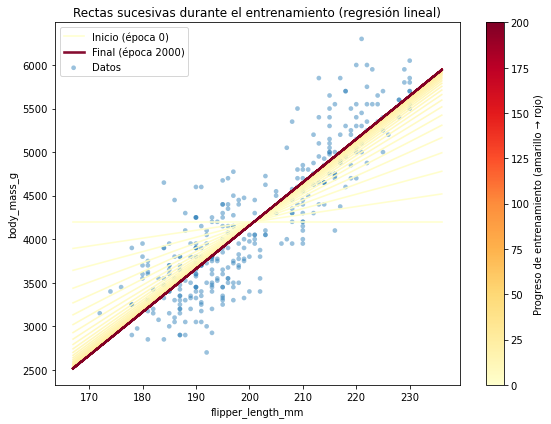

In [131]:
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Hiperparámetros para la demo de líneas sucesivas
n_epochs   = 2000
lr         = 0.01
plot_every = 10  # guarda una recta cada 200 épocas (ajustalo a gusto)

# Re-entrenamos desde cero SOLO para capturar snapshots (no afecta tus tensores x,y ya creados)
torch.manual_seed(0)
w = torch.zeros(1, 1, requires_grad=True)
b = torch.zeros(1,    requires_grad=True)
loss_fn = torch.nn.MSELoss()

# Guardamos (w,b,epoch,loss) en lista
snaps = []
for epoch in range(n_epochs + 1):
    y_hat_n = x_n @ w + b
    loss = loss_fn(y_hat_n, y_n)

    # Guardar snapshot
    if epoch % plot_every == 0 or epoch == n_epochs:
        snaps.append((w.detach().clone(), b.detach().clone(), epoch, float(loss.item())))

    # Paso de entrenamiento (gradiente manual)
    loss.backward()
    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad
        w.grad.zero_()
        b.grad.zero_()

In [132]:
w

tensor([[0.8712]], requires_grad=True)

In [133]:
b

tensor([1.4171e-07], requires_grad=True)

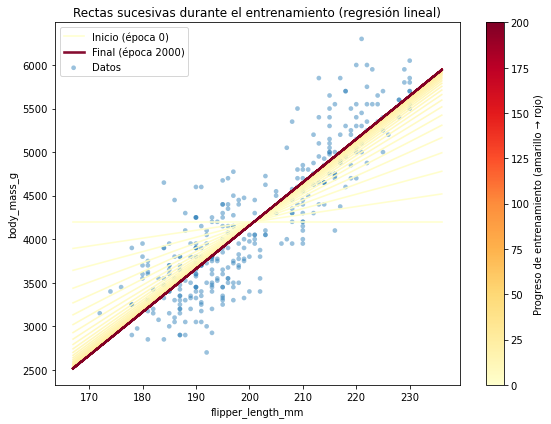

In [134]:
# --- Plot: puntos + rectas sucesivas (amarillo → rojo) ---
plt.figure(figsize=(8, 6))

# Puntos (datos en escala original)
plt.scatter(x.numpy().ravel(), y.numpy().ravel(), s=22, alpha=0.45, edgecolor='none', label="Datos")

# Rango para dibujar las rectas
x_min, x_max = x.min().item(), x.max().item()
pad = 5.0
x_plot = torch.linspace(x_min - pad, x_max + pad, 200).view(-1, 1)
x_plot_n = (x_plot - x_mean) / (x_std + 1e-8)

# Colormap amarillo->rojo
cmap = plt.get_cmap("YlOrRd")
norm = mcolors.Normalize(vmin=0, vmax=len(snaps) - 1)

for i, (w_i, b_i, ep, L) in enumerate(snaps):
    y_plot = (x_plot_n @ w_i + b_i) * y_std + y_mean
    color = cmap(norm(i))
    lw = 1.6 if i < len(snaps) - 1 else 2.6
    alpha = 0.95 if i < len(snaps) - 1 else 0.95
    label = None
    if i == 0:
        label = f"Inicio (época {ep})"
    if i == len(snaps) - 1:
        label = f"Final (época {ep})"
    plt.plot(x_plot.numpy().ravel(),
             y_plot.detach().numpy().ravel(),
             color=color, linewidth=lw, alpha=alpha, label=label)

# Colorbar del progreso
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label("Progreso de entrenamiento (amarillo → rojo)")

plt.xlabel("flipper_length_mm")
plt.ylabel("body_mass_g")
plt.title("Rectas sucesivas durante el entrenamiento (regresión lineal)")
plt.legend()
plt.tight_layout()
plt.show()
